# Connect Eye-AI and Load Libraries

In [41]:
repo_dir = "Repos"   # Set this to be where your github repos are located.
%load_ext autoreload
%autoreload 2

# # Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-ml"))
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-exec"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# Prerequisites
import json
import os
import shutil
from PIL import Image

# EyeAI, Deriva, VGG19
from deriva_ml import DatasetSpec, DatasetBag, Workflow, ExecutionConfiguration, VersionPart
from deriva_ml import MLVocab as vc
from eye_ai.eye_ai import EyeAI
from models.vgg19 import vgg19_diagnosis_train

# ML Analytics
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Other Utilities
from pathlib import Path, PurePath
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

In [43]:
# Login
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
host = 'www.eye-ai.org'
#host = 'dev.eye-ai.org' #for dev testing
catalog_id = "eye-ai"

gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-07-30 13:48:18,347 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-07-30 13:48:18,352 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


# Configuration

In [44]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-07-30 13:48:20,029 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-07-30 13:48:20,030 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [45]:
# Increment dataset if changed

# EA.increment_dataset_version(dataset_rid='4-YWKJ', component= VersionPart.patch, description='Update after annotations added')

In [46]:
source_dataset = "4-411G" #"4-YWKJ" # USC test set
crop = True

if crop:
    asset_RID = ["4-MWQ6"]  # VGG19 cropped
else:
    asset_RID = ["4-MWQ8"]  # VGG19 uncropped

preds_workflow = EA.add_workflow( 
    Workflow(
        name="VGG Predictions by KB",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/VGG_Multi_Predict.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=[ DatasetSpec(rid=source_dataset, version=EA.dataset_version(source_dataset), materialize=True) ],
    assets=asset_RID,
    workflow=preds_workflow,
    description=f"Instance of creating VGG19 predictions: VGG19 on 4-411G USC Test with Crop = {crop}",
    )

execution = EA.create_execution(config)

2025-07-30 13:49:20,172 - INFO - Execution Aborted
Exception ignored in: <function DerivaML.__del__ at 0x7fab8c1cb7f0>
Traceback (most recent call last):
  File "/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/deriva_ml/deriva_ml_base.py", line 158, in __del__
    self._execution.update_status(Status.aborted, "Execution Aborted")
  File "/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/pydantic/_internal/_validate_call.py", line 38, in wrapper_function
    return wrapper(*args, **kwargs)
  File "/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/pydantic/_internal/_validate_call.py", line 111, in __call__
    res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))
  File "/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/deriva_ml/execution.py", line 409, in update_status
    self._ml_object.pathBuilder.schemas[self._ml_object.ml_schema].Execution.update(


In [47]:
print(execution)

caching_dir: /data
_working_dir: /data/kb_766/EyeAI_working
execution_rid: 5-2EXP
workflow_rid: 5-26KP
asset_paths: {'Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/5-2EXP/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Cropped_2-277G_Feb_14_2025.h5')]}
configuration: datasets=[DatasetSpec(rid='4-411G', materialize=True, version=DatasetVersion(major=2, minor=7, patch=0))] assets=['4-MWQ6'] workflow='5-26KP' parameters={} description='Instance of creating VGG19 predictions: VGG19 on 4-411G USC Test with Crop = True' argv=['/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-53b81482-309f-428d-9422-74fb6f1dc323.json']


In [48]:
output_dir = execution._working_dir / execution.execution_rid

# Organize Data into Directories for ML

In [49]:
ds_bag_test = execution.datasets[0]

In [54]:
# FOR USC MULTIMODAL DATA
# Group files as glaucoma/not for VGG evaluation

imageDF = ds_bag_test.get_table_as_dataframe('Image')
annotation_bounding_box =  pd.merge( ds_bag_test.get_table_as_dataframe('Annotation')[['Image', 'Fundus_Bounding_Box']], 
                                                ds_bag_test.get_table_as_dataframe('Fundus_Bounding_Box'), 
                                                left_on='Fundus_Bounding_Box', 
                                                right_on='RID')

output_path =  output_dir / "Test"
output_path_healthy = output_path / "No_Glaucoma"
output_path_glaucoma = output_path / "Suspected_Glaucoma"

output_path.mkdir(parents=True, exist_ok=True)
output_path_healthy.mkdir(parents=True, exist_ok=True)
output_path_glaucoma.mkdir(parents=True, exist_ok=True)

for index, row in imageDF.iterrows():     
    src_path = row["Filename"]
    image_rid = row["RID"]
    dest_name = image_rid + ".jpg"
    if crop: dest_name = "Crop_" + dest_name
    dest_path = os.path.join(output_path_glaucoma, dest_name)

    # Rule for labeling in my external USC test set
    # label = image_rid.split( sep = "-" )[0]
    # if label == "4":
    #     dest_path = os.path.join(output_path_suspected, dest_name)
    # elif label == "2":
    #     dest_path = os.path.join(output_path_glaucoma, dest_name)
    # else: 
    #     continue    
    
    if crop:
        image = Image.open(src_path)
        svg_path = annotation_bounding_box.loc[annotation_bounding_box['Image'] == image_rid, 'Filename'].values[0]
        svg_path = Path(svg_path)
        if not svg_path.exists():
          continue
        bbox = EA.get_bounding_box(svg_path)
        cropped_image = image.crop(bbox)
        cropped_image.save(dest_path)
    else:
        shutil.copy2(src_path, dest_path)

output_path

PosixPath('/data/kb_766/EyeAI_working/5-2EXP/Test')

In [59]:
!ls /data/kb_766/EyeAI_working/5-2EXP/Test/Suspected_Glaucoma -1 | wc -l

343


# Run ML

In [60]:
asset_output_dir = execution._working_dir / execution.execution_rid / "asset"
asset_output_dir.mkdir( parents=True, exist_ok=True )

In [61]:
current_date = datetime.now().strftime("%b_%d_%Y") 

In [62]:
model_path = str(execution.asset_paths['Execution_Asset'][0])

In [63]:

with execution.execute() as exec:
        predictions_results, metrics_summary = vgg19_diagnosis_train.evaluate_only(
            model_path = model_path, 
            model_name = f"VGG19_Cropped_Model_{ds_bag_test.dataset_rid}_{current_date}", 
            test_path = output_path, 
            output_dir = asset_output_dir,
            classes = {'No_Glaucoma': 0, 'Suspected_Glaucoma': 1}
        )
        print("Execution Results:")
        print(predictions_results, metrics_summary)

2025-07-30 13:54:15,017 - INFO - Start execution  ...
2025-07-30 13:54:15,114 - INFO - Start execution  ...
2025-07-30 13:54:15.514927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-30 13:54:15.928094: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-30 13:54:15.929724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node

Found 343 images belonging to 2 classes.


2025-07-30 13:54:18.190169: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-07-30 13:54:27,030 - INFO - Predictions saved to VGG19_Cropped_Model_4-411G_Jul_30_2025_predictions_results.csv
2025-07-30 13:54:27,031 - INFO - Metrics saved to VGG19_Cropped_Model_4-411G_Jul_30_2025_metrics_summary.csv
2025-07-30 13:54:27,035 - INFO - Successfully run Ml.
2025-07-30 13:54:27,105 - INFO - Algorithm execution ended.


Execution Results:
/data/kb_766/EyeAI_working/5-2EXP/asset/VGG19_Cropped_Model_4-411G_Jul_30_2025_predictions_results.csv /data/kb_766/EyeAI_working/5-2EXP/asset/VGG19_Cropped_Model_4-411G_Jul_30_2025_metrics_summary.csv


# Evaluate ML

In [64]:
pd.read_csv( metrics_summary )

,Metric,Value
0,F1 Score,0.8528428093645485
1,Precision,1.0
2,Recall,0.7434402332361516
3,Accuracy,0.7434402332361516
4,ROC-AUC,Undefined (only one class)


In [91]:
preds = pd.read_csv( predictions_results )
preds['Image']=preds['Filename'].str.extract(r'Crop_(.+?)\.jpg$')
preds

,Filename,True Label,Prediction,Probability Score,Image
0,Suspected_Glaucoma/Crop_2-BDCW.jpg,1.0,1,0.993956,2-BDCW
1,Suspected_Glaucoma/Crop_2-BDHR.jpg,1.0,1,0.994846,2-BDHR
2,Suspected_Glaucoma/Crop_2-BDME.jpg,1.0,1,0.884743,2-BDME
3,Suspected_Glaucoma/Crop_2-BDMY.jpg,1.0,0,0.216373,2-BDMY
4,Suspected_Glaucoma/Crop_2-BDQT.jpg,1.0,1,0.938646,2-BDQT
...,...,...,...,...,...
338,Suspected_Glaucoma/Crop_2-C38C.jpg,1.0,0,0.092451,2-C38C
339,Suspected_Glaucoma/Crop_2-C38R.jpg,1.0,1,0.987421,2-C38R
340,Suspected_Glaucoma/Crop_2-C3DG.jpg,1.0,1,0.990156,2-C3DG
341,Suspected_Glaucoma/Crop_2-C3JM.jpg,1.0,1,0.995290,2-C3JM


In [ ]:
wide_t = EA.multimodal_wide(ds_bag_test)

In [118]:
mergeDF = pd.merge(
    imageDF[['RID', 'Observation']],
    ds_bag_test.get_table_as_dataframe('Execution_Image_Fundus_Laterality')[['Image', 'Image_Side']],
    left_on = 'RID', right_on = 'Image',
    how = 'left'
)[['Image', 'Image_Side', 'Observation']]

mergeDF = pd.merge(
    mergeDF,
    ds_bag_test.get_table_as_dataframe('Observation')[['RID', 'Subject']],
    left_on = 'Observation', right_on = 'RID',
    how = 'left'
)[['Image', 'Image_Side', 'Observation', 'Subject']]

mergeDF = pd.merge(
    mergeDF,
    preds[['Image', 'Prediction']],
    on = 'Image',
    how = 'left'
)[['Image', 'Image_Side', 'Observation', 'Subject', 'Prediction']]

mergeDF = pd.merge(
    mergeDF,
    wide_t[['RID_Subject', 'Image_Side', 'CDR']],
    left_on = ['Subject', 'Image_Side'], right_on = ['RID_Subject', 'Image_Side'],
    how = 'left'
)[['Image', 'Image_Side', 'Observation', 'Subject', 'Prediction', 'CDR']]

mergeDF = pd.merge(
    mergeDF,
    ds_bag_test.get_table_as_dataframe('Execution_Subject_Chart_Label')[['Subject','Image_Side','Condition_Label']],
    on = ['Subject', 'Image_Side'],
    how = 'left'
)[['Image', 'Image_Side', 'Observation', 'Subject', 'Prediction', 'CDR', 'Condition_Label']]


mergeDF
    

,Image,Image_Side,Observation,Subject,Prediction,CDR,Condition_Label
0,2-BDCW,Left,2-7SCG,2-7M7W,1,0.7,POAG
1,2-BDHR,Left,2-7S1G,2-7M2J,1,0.85,POAG
2,2-BDME,Left,2-7VT2,2-7NC8,1,0.75,Other
3,2-BDMY,Right,2-7VMT,2-7N9P,0,0.4,GS
4,2-BDQT,Left,2-7XDW,2-7P4R,1,0.7,GS
...,...,...,...,...,...,...,...
338,2-C38C,Left,2-7SM8,2-7MBG,0,0.45,POAG
339,2-C38R,Left,2-7WHJ,2-7NQG,1,0.7,POAG
340,2-C3DG,Right,2-7VX0,2-7NDP,1,0.9,POAG
341,2-C3JM,Right,2-7S1G,2-7M2J,1,0.95,POAG


In [120]:
mergeDF[mergeDF['Prediction'] == 0]['Condition_Label'].value_counts()

Condition_Label
POAG               51
GS                 35
Normal or No dx     2
Name: count, dtype: int64

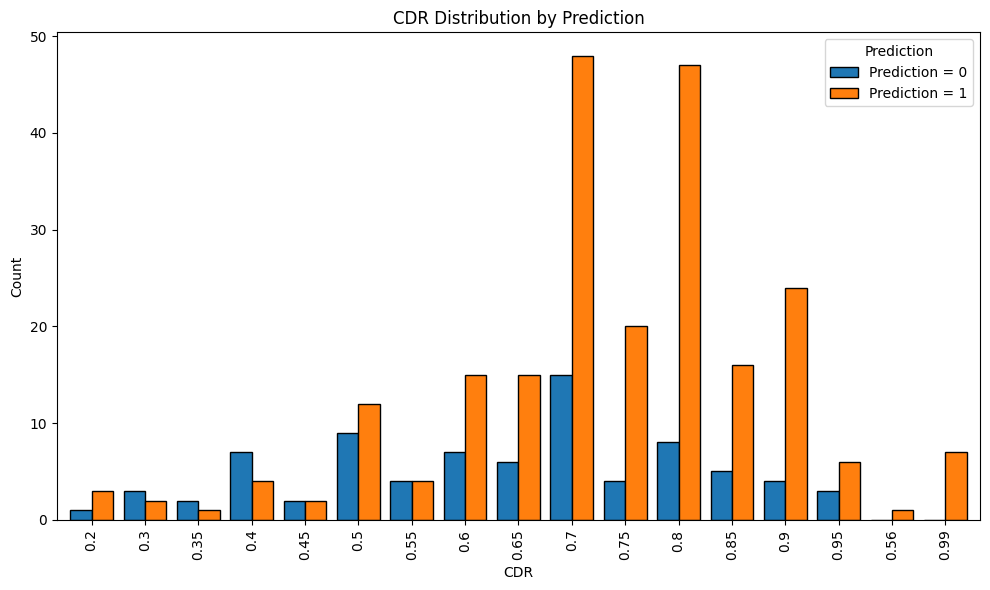

In [107]:
# Ensure CDR is float and rounded
mergeDF['CDR'] = pd.to_numeric(mergeDF['CDR'], errors='coerce')
mergeDF['CDR'] = mergeDF['CDR'].round(2)

# Count CDR values by Prediction
cdr_1 = mergeDF[mergeDF['Prediction'] == 1]['CDR'].value_counts().sort_index()
cdr_0 = mergeDF[mergeDF['Prediction'] == 0]['CDR'].value_counts().sort_index()

# Combine into a single DataFrame
cdr_df = pd.concat([cdr_0, cdr_1], axis=1)
cdr_df.columns = ['Prediction = 0', 'Prediction = 1']
cdr_df = cdr_df.fillna(0)  # Fill NaNs with 0 where a CDR is missing in one group

# Plot grouped bar chart
cdr_df.plot(kind='bar', figsize=(10, 6), width=0.8, edgecolor='black')

# Labels and title
plt.xlabel('CDR')
plt.ylabel('Count')
plt.title('CDR Distribution by Prediction')
plt.legend(title='Prediction')
plt.tight_layout()
plt.show()

In [126]:
(cdr_0 < 0.6).mean() * 100, (cdr_0 >= 0.6).mean() * 100, (cdr_1 < 0.6).mean() * 100, (cdr_1 >= 0.6).mean() * 100

(35.0, 65.0, 12.77533039647577, 87.22466960352423)

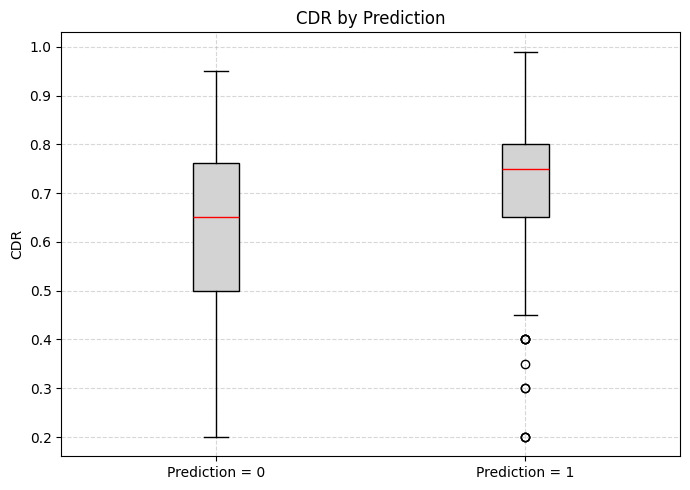

Mann–Whitney U test: U = 6219.00, p = 2.38e-05


In [110]:
from scipy.stats import mannwhitneyu

# Ensure CDR is numeric and rounded
mergeDF['CDR'] = pd.to_numeric(mergeDF['CDR'], errors='coerce')
mergeDF['CDR'] = mergeDF['CDR'].round(2)

# Get CDRs by prediction group
cdr_0 = mergeDF[mergeDF['Prediction'] == 0]['CDR'].dropna()
cdr_1 = mergeDF[mergeDF['Prediction'] == 1]['CDR'].dropna()

# Boxplot
plt.figure(figsize=(7, 5))
plt.boxplot([cdr_0, cdr_1], labels=['Prediction = 0', 'Prediction = 1'], patch_artist=True,
            boxprops=dict(facecolor='lightgray'),
            medianprops=dict(color='red'))
plt.ylabel('CDR')
plt.title('CDR by Prediction')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Statistical test: Mann–Whitney U (non-parametric alternative to t-test)
stat, p = mannwhitneyu(cdr_0, cdr_1, alternative='two-sided')
print(f"Mann–Whitney U test: U = {stat:.2f}, p = {p:.2e}")


In [72]:
import matplotlib.pyplot as plt
import sklearn.metrics as sk

cm = sk.confusion_matrix(preds['True Label'], preds['Prediction'])
tn, fp, fn, tp = cm.ravel()
print( "Sensitivity = ", round( tp / (tp + fn), 2 ) )
print( "Specificity = ", round( tn / (tn + fp), 2 ) )
print( "Accuracy = ", round( (tp + tn) / (tp + tn + fp + fn), 2 ), "\n" )
disp = sk.ConfusionMatrixDisplay( cm )

Sensitivity =  0.74
Specificity =  nan
Accuracy =  0.74 



/tmp/ipykernel_28653/118157946.py:7: RuntimeWarning: invalid value encountered in scalar divide
  print( "Specificity = ", round( tn / (tn + fp), 2 ) )


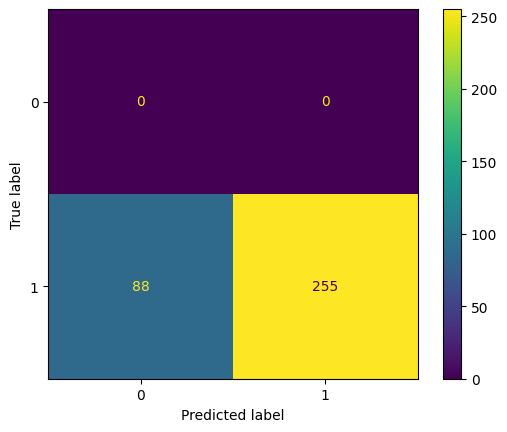

In [73]:
disp.plot()
plt.show()

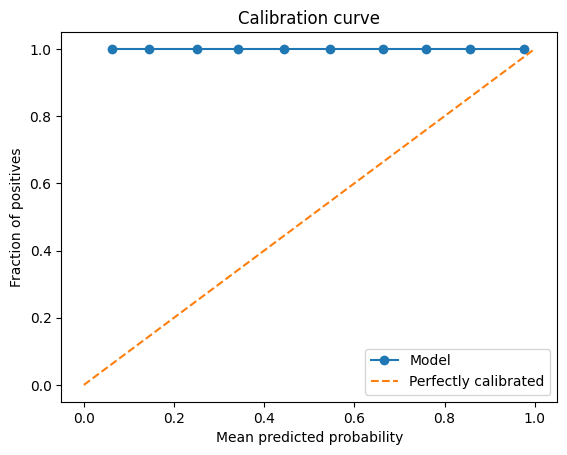

In [66]:
# Calibration curve
prob_true, prob_pred = calibration_curve( preds["True Label"], preds["Probability Score"], n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()

# Upload Results

In [74]:
#This loop creates copies.
for filename in os.listdir(asset_output_dir):
    file_path = os.path.join(asset_output_dir, filename)
    if os.path.isfile(file_path):
        asset_type = ""
        if filename.endswith(('csv', 'jpg', 'txt')):
            asset_type = "Model_Prediction"
        elif filename.endswith('pth'):
            asset_type = "Diagnosis_Model"
        if asset_type != "":
            path = execution.asset_file_path(
                asset_name="Execution_Asset",
                file_name=file_path,
                asset_types=asset_type
            )


In [75]:
# upload assets to catalog
exec.upload_execution_outputs(clean_folder=True)

2025-07-30 14:23:45,785 - INFO - Uploading execution files...
2025-07-30 14:23:45,835 - INFO - Initializing uploader: GenericUploader v1.7.7 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2025-07-30 14:23:45,836 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-07-30 14:23:45,837 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-07-30 14:23:45,874 - INFO - Scanning files in directory [/data/kb_766/EyeAI_working/deriva-ml/execution/5-2EXP/asset]...
2025-07-30 14:23:45,877 - INFO - Including file: [/data/kb_766/EyeAI_working/deriva-ml/execution/5-2EXP/asset/deriva-ml/Execution_Metadata/configuration.json].
2025-07-30 14:23:45,878 - INFO - Including file: [/data/kb_766/EyeAI_working/deriva-ml/execution/5-2EXP/asset/deriva-ml/Execution_Metadata/environment_sn

{'deriva-ml/Execution_Metadata': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/5-2EXP/asset/deriva-ml/Execution_Metadata/configuration.json'),
  AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/5-2EXP/asset/deriva-ml/Execution_Metadata/environment_snapshot_20250730_134928.txt')],
 'deriva-ml/Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/5-2EXP/asset/deriva-ml/Execution_Asset/VGG19_Cropped_Model_4-411G_Jul_30_2025_predictions_results.csv'),
  AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/5-2EXP/asset/deriva-ml/Execution_Asset/VGG19_Cropped_Model_4-411G_Jul_30_2025_metrics_summary.csv')]}